# 02 - Sea Glider - Pre-calculations

## Calculate TEOS-10 variables and distance (before gridding/interpolation)

In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cmocean.cm as cmo
from matplotlib.ticker import StrMethodFormatter
from matplotlib.ticker import FuncFormatter
import matplotlib.dates as mdates
from matplotlib.colors import Normalize
import pathlib
from pathlib import Path
import os
import netCDF4
from netCDF4 import Dataset as nc
import glob
from glob import glob
import glidertools as gt
import gsw
import csv
import sys
import array

import warnings
warnings.simplefilter("ignore", UserWarning)
def write_with_byte_inversion(f, tab):
    tab2write = array.array('f', tab.T.flatten())
    if sys.byteorder == 'little':
        tab2write.byteswap()
    f.write(tab2write)

dtype=np.float32

### Open dataset

In [2]:
ds = xr.open_dataset(r"Data\01_ds_qc.nc")

In [3]:
ds

<xarray.Dataset>
Dimensions:                   (sg_data_point: 422669)
Coordinates:
    ctd_depth                 (sg_data_point) float64 ...
    longitude                 (sg_data_point) float64 ...
    latitude                  (sg_data_point) float64 ...
    ctd_time_dt64             (sg_data_point) datetime64[ns] ...
Dimensions without coordinates: sg_data_point
Data variables: (12/35)
    time_dt64                 (sg_data_point) datetime64[ns] ...
    depth                     (sg_data_point) float64 ...
    speed_gsm                 (sg_data_point) float64 ...
    ctd_time                  (sg_data_point) datetime64[ns] ...
    pressure                  (sg_data_point) float64 ...
    ctd_pressure              (sg_data_point) float64 ...
    ...                        ...
    theta                     (sg_data_point) float64 ...
    north_displacement_gsm    (sg_data_point) float64 ...
    sigma_theta               (sg_data_point) float64 ...
    salinity                  (sg_data_point) float64 ...
    temp_qc                   (sg_data_point) float64 ...
    salt_qc                   (sg_data_point) float64 ...
Attributes:
    date_created:             2025-10-20 14:26:06
    number_of_dives:          128.0
    files:                    ['C:\\Users\\lollo\\OneDrive - University of Go...
    time_coverage_start:      2025-09-17 10:20:17
    time_coverage_end:        2025-10-13 10:53:44
    geospatial_vertical_min:  -0.2958712021631342
    geospatial_vertical_max:  993.9760316575006
    geospatial_lat_min:       -35.49119608233423
    geospatial_lat_max:       -33.341316666666664
    geospatial_lon_min:       11.073439521461031
    geospatial_lon_max:       13.845082465738725
    processing:               [2025-10-20 14:26:06] imported data with Glider...

## Calculate TEOS-10 variables using gsw

https://teos-10.github.io/GSW-Python/conversions.html

I do this using temp_qc and salt_qc (cleaned based on 'temperature' and 'salinity' in previous notebook), since I don't trust their already provided calculated variables.

Other option is to directly use 'conservative_temperature' and 'absolute_salinity' from the dataset and qc filter them.

In [4]:
# Välj ingångsserier (QC:ade)
SP = ds["salt_qc"]        # PSS-78 (enhetslös/PSU)
t  = ds["temp_qc"]     # in-situ °C
p  = ds["ctd_pressure"]    # dbar
lon = ds["longitude"]      # degrees_east
lat = ds["latitude"]       # degrees_north

In [5]:
# Absolute salinity unit: g/kg
SA = xr.apply_ufunc(
    gsw.SA_from_SP, SP, p, lon, lat,
    vectorize=True)

# Conservative temperature unit: DegC
CT = xr.apply_ufunc(
    gsw.CT_from_t, SA, t, p,
    vectorize=True)

# Density: sigma0 and in-situ rho
sigma0 = xr.apply_ufunc(
    gsw.sigma0, SA, CT,
    vectorize=True)

rho = xr.apply_ufunc(
    gsw.rho, SA, CT, p,
    vectorize=True)

#    input_core_dims=[[], [], [], []],
#    output_core_dims=[[]], dask="parallelized",

In [6]:
# Lägg in i datasetet med vettiga attribut
ds["SA"] = SA.assign_attrs({
    "long_name": "Absolute Salinity",
    "units": "g/kg",
    "standard_name": "sea_water_absolute_salinity",
    "history": "TEOS-10 from salinity (SP), ctd_pressure, lon/lat; QC inputs",
})
ds["CT"] = CT.assign_attrs({
    "long_name": "Conservative Temperature",
    "units": "degC",
    "standard_name": "sea_water_conservative_temperature",
    "history": "TEOS-10 from SA,t,p; QC inputs",
})

ds["sigma0"] = sigma0.assign_attrs({
    "long_name": "Potential density anomaly (sigma0, ref 0 dbar)",
    "units": "kg/m^3",
    "history": "TEOS-10 from SA,CT; QC inputs",
})
ds["rho_insitu"] = rho.assign_attrs({
    "long_name": "In-situ density",
    "units": "kg/m^3",
    "history": "TEOS-10 from SA,CT,p; QC inputs",
})

In [7]:
ds

<xarray.Dataset>
Dimensions:                   (sg_data_point: 422669)
Coordinates:
    ctd_depth                 (sg_data_point) float64 0.3879 0.451 ... -0.2057
    longitude                 (sg_data_point) float64 nan nan ... 13.85 13.85
    latitude                  (sg_data_point) float64 nan nan ... -35.4 -35.4
    ctd_time_dt64             (sg_data_point) datetime64[ns] 2025-09-17T10:20...
Dimensions without coordinates: sg_data_point
Data variables: (12/39)
    time_dt64                 (sg_data_point) datetime64[ns] ...
    depth                     (sg_data_point) float64 ...
    speed_gsm                 (sg_data_point) float64 ...
    ctd_time                  (sg_data_point) datetime64[ns] ...
    pressure                  (sg_data_point) float64 ...
    ctd_pressure              (sg_data_point) float64 0.3911 0.4546 ... -0.2071
    ...                        ...
    temp_qc                   (sg_data_point) float64 nan nan ... 17.89 17.89
    salt_qc                   (sg_data_point) float64 nan nan nan ... nan nan
    SA                        (sg_data_point) float64 nan nan nan ... nan nan
    CT                        (sg_data_point) float64 nan nan nan ... nan nan
    sigma0                    (sg_data_point) float64 nan nan nan ... nan nan
    rho_insitu                (sg_data_point) float64 nan nan nan ... nan nan
Attributes:
    date_created:             2025-10-20 14:26:06
    number_of_dives:          128.0
    files:                    ['C:\\Users\\lollo\\OneDrive - University of Go...
    time_coverage_start:      2025-09-17 10:20:17
    time_coverage_end:        2025-10-13 10:53:44
    geospatial_vertical_min:  -0.2958712021631342
    geospatial_vertical_max:  993.9760316575006
    geospatial_lat_min:       -35.49119608233423
    geospatial_lat_max:       -33.341316666666664
    geospatial_lon_min:       11.073439521461031
    geospatial_lon_max:       13.845082465738725
    processing:               [2025-10-20 14:26:06] imported data with Glider...

In [8]:
x = np.array(ds.dives)  # ensures these are arrays
y = np.array(ds.ctd_depth)

C:\Users\lollo\miniconda3\envs\master\Lib\site-packages\glidertools\mapping.py:969: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = Series(z).groupby([x, bins])  # -DB put z into the many bins (like 2D hist)
C:\Users\lollo\miniconda3\envs\master\Lib\site-packages\glidertools\mapping.py:969: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = Series(z).groupby([x, bins])  # -DB put z into the many bins (like 2D hist)
C:\Users\lollo\miniconda3\envs\master\Lib\site-packages\glidertools\mapping.py:969: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version o

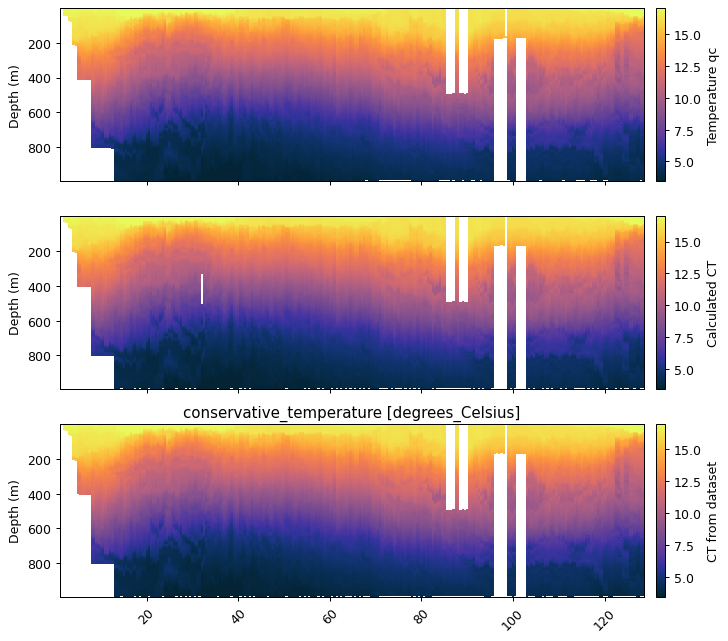

In [9]:
fig, ax = plt.subplots(3, 1, figsize=[9, 8.5], sharex=True, dpi=90)

gt.plot(x, y, ds.temp_qc, cmap=cmo.thermal, ax=ax[0])
gt.plot(x, y, CT, cmap=cmo.thermal, ax=ax[1])
gt.plot(x, y, ds.conservative_temperature, cmap=cmo.thermal, ax=ax[2])

[a.set_xlabel('') for a in ax]

ax[0].cb.set_label('Temperature qc')
ax[1].cb.set_label('Calculated CT')
ax[2].cb.set_label('CT from dataset')

plt.show()

C:\Users\lollo\miniconda3\envs\master\Lib\site-packages\glidertools\mapping.py:969: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = Series(z).groupby([x, bins])  # -DB put z into the many bins (like 2D hist)
C:\Users\lollo\miniconda3\envs\master\Lib\site-packages\glidertools\mapping.py:969: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = Series(z).groupby([x, bins])  # -DB put z into the many bins (like 2D hist)
C:\Users\lollo\miniconda3\envs\master\Lib\site-packages\glidertools\mapping.py:969: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version o

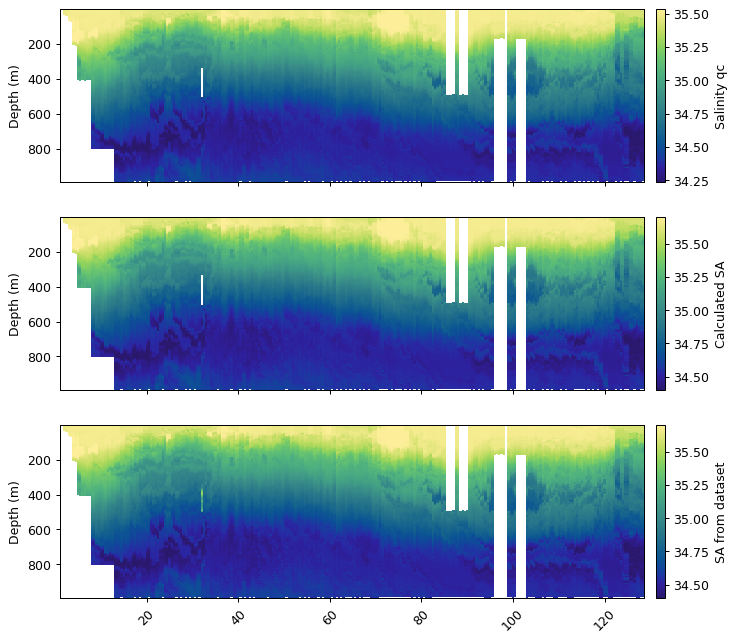

In [10]:
fig, ax = plt.subplots(3, 1, figsize=[9, 8.5], sharex=True, dpi=90)

gt.plot(x, y, ds.salt_qc, cmap=cmo.haline, ax=ax[0])
gt.plot(x, y, SA, cmap=cmo.haline, ax=ax[1])
gt.plot(x, y, ds.absolute_salinity, cmap=cmo.haline, ax=ax[2])

[a.set_xlabel('') for a in ax]

ax[0].cb.set_label('Salinity qc')
ax[1].cb.set_label('Calculated SA')
ax[2].cb.set_label('SA from dataset')

plt.show()

In [11]:
mask_T  = np.isfinite(ds.temp_qc)
mask_SP = np.isfinite(ds.salt_qc)
mask_CT = np.isfinite(CT)

print("Andel där temp_qc finns men CT saknas:", (mask_T & ~mask_CT).mean().item())
print("Andel där salt_qc finns men CT saknas:", (mask_SP & ~mask_CT).mean().item())
print("Andel där temp_qc & salt_qc finns men CT saknas:", (mask_T & mask_SP & ~mask_CT).mean().item())

# Om CT saknas trots att T & SP finns, kolla värdeintervall (kan vara ogiltigt för TEOS-10)
suspect = mask_T & mask_SP & ~mask_CT
if suspect.any():
    print("SP min/max där CT saknas:",
          float(SP.where(suspect).min()), float(SP.where(suspect).max()))
    print("p min/max där CT saknas:",
          float(ds.ctd_pressure.where(suspect).min()),
          float(ds.ctd_pressure.where(suspect).max()))

Andel där temp_qc finns men CT saknas: 0.01577357222791357
Andel där salt_qc finns men CT saknas: 0.0
Andel där temp_qc & salt_qc finns men CT saknas: 0.0


## Get distance relative to current

### Check 'delta_time_s' variable - fint out if it's necessary to use this one or just set a fixed t

In [12]:
any_dt = ds.delta_time_s.groupby(ds.dives).apply(lambda a: a.notnull().any())
missing_dives = any_dt.where(~any_dt).dropna("dives")
print("Dives utan delta_time_s:", list(missing_dives["dives"].values))

Dives utan delta_time_s: [1.0, 1.5, 84.0, 84.5, 85.0, 85.5, 86.0, 86.5, 87.0, 87.5, 88.0, 88.5, 89.0, 89.5, 90.0, 90.5]


In [13]:
dt = ds["delta_time_s"]
n_total = ds.dims["sg_data_point"]
n_nan = np.isnan(ds["delta_time_s"]).sum().item()

print(dt.min().item(), dt.max().item(), dt.mean().item())
print(f"NaN i delta_time_s: {n_nan} av {n_total} ({100*n_nan/n_total:.1f}%)")

0.0 21.656999826431274 4.9790482304439205
NaN i delta_time_s: 31215 av 422669 (7.4%)


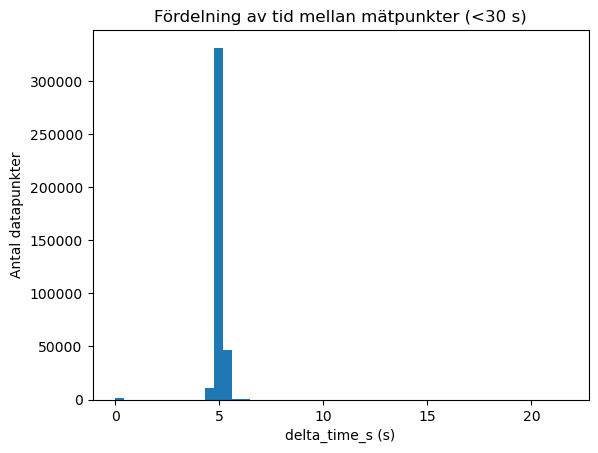

In [14]:
plt.hist(ds["delta_time_s"].where(ds["delta_time_s"]<30), bins=50)
plt.xlabel("delta_time_s (s)")
plt.ylabel("Antal datapunkter")
plt.title("Fördelning av tid mellan mätpunkter (<30 s)")
plt.show()

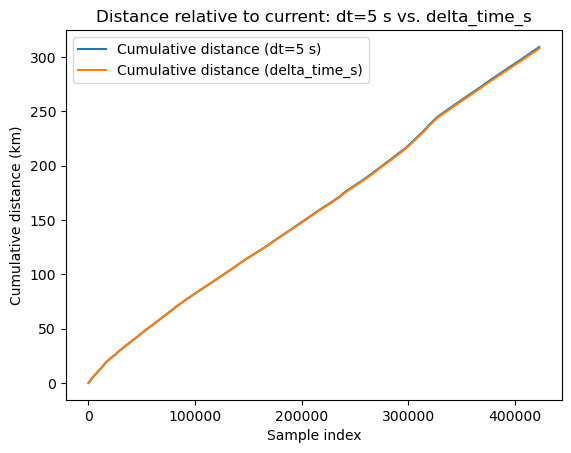

(309.1981658960463,
 307.7899780443487,
 -1.408187851697619,
 -0.45543214902867746)

In [15]:
# 1) Speed-through-water from GSM (cm/s) -> convert to m/s
u_cm_s = ds["horz_speed_gsm"].fillna(0)
u_ms = u_cm_s / 100.0  # m/s

# 2) Gentle 2-point smoothing (as in your friend's notebook)
u_vals = u_ms.values.astype("float64").copy()
if len(u_vals) > 0:
    u_vals[0] = 0.0
for i in range(1, len(u_vals)):
    u_vals[i] = 0.5*(u_vals[i] + u_vals[i-1])
u_sm = xr.DataArray(u_vals, dims=u_ms.dims, coords=u_ms.coords)

# 3) Prepare dt arrays
dt_5s = xr.full_like(u_sm, 5.0)  # constant 5 s
if "delta_time_s" in ds:
    dt_var = ds["delta_time_s"].fillna(5.0)
    # clip to avoid weird resets; adjust bounds as you like
    dt_var = dt_var.clip(0.5, 30.0)
else:
    dt_var = dt_5s

# 4) Step distances and cumulative (meters and kilometers)
dist_step_5s_m = (u_sm * dt_5s).values                   # m per step
dist_step_dtvar_m = (u_sm * dt_var).values               # m per step

cum_5s_km = np.cumsum(dist_step_5s_m) / 1000.0
cum_dtvar_km = np.cumsum(dist_step_dtvar_m) / 1000.0

# 5) Plot comparison (no specific colors, single plot as required)
plt.figure()
plt.plot(cum_5s_km, label="Cumulative distance (dt=5 s)")
plt.plot(cum_dtvar_km, label="Cumulative distance (delta_time_s)")
plt.xlabel("Sample index")
plt.ylabel("Cumulative distance (km)")
plt.title("Distance relative to current: dt=5 s vs. delta_time_s")
plt.legend()
plt.show()

# 6) Print quick numeric summary of final totals
final_5s = float(cum_5s_km[-1])
final_dtvar = float(cum_dtvar_km[-1])
diff_abs = final_dtvar - final_5s
diff_rel = 100.0 * diff_abs / final_5s if final_5s != 0 else np.nan
(final_5s, final_dtvar, diff_abs, diff_rel)

#### Barely any difference - so we can use t = 5s instead of delta_time_s

$$
\mathbf{u}_{\mathrm{rel}}(t) = \mathbf{u}_{\mathrm{glider}}(t) - \mathbf{u}_{\mathrm{curr}}(t)
$$

$$
s(t) = \int_{t_0}^{t} \|\mathbf{u}_{\mathrm{rel},h}(\tau)\| \, \mathrm{d}\tau
$$

$$
\Delta s_i = \frac{u_{h,i-1} + u_{h,i}}{2} \, \Delta t, \quad s_n = \sum_{i=1}^{n} \Delta s_i
$$

$$
s_{\mathrm{GPS}} = \sum_{i=1}^{n} d_{\mathrm{gc}}(\mathrm{pos}_{i-1}, \mathrm{pos}_i)
$$


In [16]:
# 1) Plocka ut horisontell GSM-hastighet (cm/s)
u = ds["horz_speed_gsm"].fillna(0).astype("float64").values  # cm/s

# 2) Two-point averaging (trapezoidal step):
# - Smooths high-frequency noise/outliers in horizontal speed.
# - Uses (u[i] + u[i-1]) / 2 to approximate the mean speed over the interval,
#   which is equivalent to trapezoidal integration and yields a more accurate
#   distance than using u[i] * dt directly.
if len(u) > 0:
    u[0] = 0.0
for i in range(1, len(u)):
    u[i] = 0.5*(u[i] + u[i-1])

# 3) Timesteps
dt = 5.0  # seconds

# 4) Stegvis distans (km/prov) och kumulativ distans (km)
distance_rel = (u * dt) / 100000.0      # cm/s * s = cm -> /100000 = km
tot_distance_rel = np.cumsum(distance_rel)  # km från start

#### Try with hdm as well to see difference

In [17]:
# --- HDM: horisontell hastighet (cm/s) ---
u_hdm = ds["horz_speed"].fillna(0).astype("float64").values  # cm/s

# Two-point averaging (trapezoidal step), exakt som för GSM
if len(u_hdm) > 0:
    u_hdm[0] = 0.0
for i in range(1, len(u_hdm)):
    u_hdm[i] = 0.5*(u_hdm[i] + u_hdm[i-1])

# Samma tidssteg som du valt
dt = 5.0  # s

# Stegvis och kumulativ distans (HDM)
distance_rel_hdm = (u_hdm * dt) / 100000.0        # km per prov
tot_distance_rel_hdm = np.cumsum(distance_rel_hdm)    # km från start

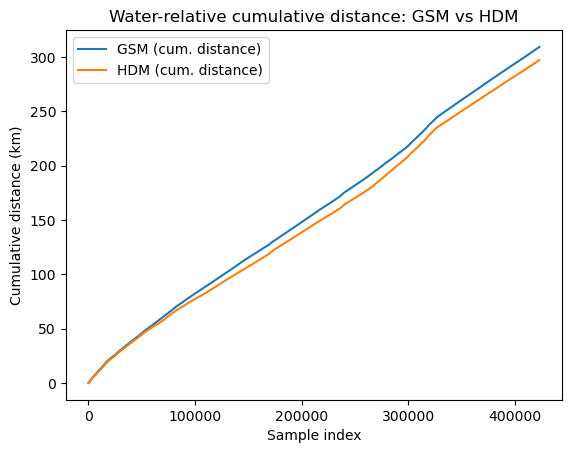

GSM total: 309.20 km | HDM total: 297.18 km | Diff: -12.02 km (-3.89%)


In [18]:
# --- Enkel jämförelseplot mot dina GSM-resultat ---
plt.figure()
plt.plot(tot_distance_rel, label="GSM (cum. distance)")
plt.plot(tot_distance_rel_hdm, label="HDM (cum. distance)")
plt.xlabel("Sample index")
plt.ylabel("Cumulative distance (km)")
plt.title("Water-relative cumulative distance: GSM vs HDM")
plt.legend()
plt.show()

# --- Snabb numerisk sammanfattning ---
gsm_total = float(tot_distance_rel[-1])
hdm_total = float(tot_distance_rel_hdm[-1])
diff_abs = hdm_total - gsm_total
diff_rel = 100.0*diff_abs/gsm_total if gsm_total != 0 else np.nan
print(f"GSM total: {gsm_total:.2f} km | HDM total: {hdm_total:.2f} km | Diff: {diff_abs:+.2f} km ({diff_rel:+.2f}%)")

### Add to dataset

In [19]:
# 5) Lägg in som koordinater i datasetet (ändrar inte dina data)
ds = ds.assign_coords(
    distance_rel=("sg_data_point", distance_rel),          # km per prov
    tot_distance_rel=("sg_data_point", tot_distance_rel),  # kumulativ km
)

In [20]:
# Sätt korta beskrivande attribut
ds["distance_rel"].attrs.update({
    "units": "km",
    "long_name": "Stepwise horizontal distance (water-relative)",
    "method": "horz_speed_gsm (cm/s) two-point average; dt=5 s; cm->km via /100000",
    "note": "Per-sample horizontal distance; excludes current drift; trapezoidal step."
})

ds["tot_distance_rel"].attrs.update({
    "units": "km",
    "long_name": "Cumulative horizontal distance (water-relative)",
    "method": "cumsum of distance_rel from GSM with dt=5 s",
    "note": "Along-track x-axis for gridding/sections; excludes current drift."
})

In [21]:
ds

<xarray.Dataset>
Dimensions:                   (sg_data_point: 422669)
Coordinates:
    ctd_depth                 (sg_data_point) float64 0.3879 0.451 ... -0.2057
    longitude                 (sg_data_point) float64 nan nan ... 13.85 13.85
    latitude                  (sg_data_point) float64 nan nan ... -35.4 -35.4
    ctd_time_dt64             (sg_data_point) datetime64[ns] 2025-09-17T10:20...
    distance_rel              (sg_data_point) float64 0.0 6.706e-06 ... 0.00186
    tot_distance_rel          (sg_data_point) float64 0.0 6.706e-06 ... 309.2
Dimensions without coordinates: sg_data_point
Data variables: (12/39)
    time_dt64                 (sg_data_point) datetime64[ns] ...
    depth                     (sg_data_point) float64 ...
    speed_gsm                 (sg_data_point) float64 ...
    ctd_time                  (sg_data_point) datetime64[ns] ...
    pressure                  (sg_data_point) float64 ...
    ctd_pressure              (sg_data_point) float64 0.3911 0.4546 ... -0.2071
    ...                        ...
    temp_qc                   (sg_data_point) float64 nan nan ... 17.89 17.89
    salt_qc                   (sg_data_point) float64 nan nan nan ... nan nan
    SA                        (sg_data_point) float64 nan nan nan ... nan nan
    CT                        (sg_data_point) float64 nan nan nan ... nan nan
    sigma0                    (sg_data_point) float64 nan nan nan ... nan nan
    rho_insitu                (sg_data_point) float64 nan nan nan ... nan nan
Attributes:
    date_created:             2025-10-20 14:26:06
    number_of_dives:          128.0
    files:                    ['C:\\Users\\lollo\\OneDrive - University of Go...
    time_coverage_start:      2025-09-17 10:20:17
    time_coverage_end:        2025-10-13 10:53:44
    geospatial_vertical_min:  -0.2958712021631342
    geospatial_vertical_max:  993.9760316575006
    geospatial_lat_min:       -35.49119608233423
    geospatial_lat_max:       -33.341316666666664
    geospatial_lon_min:       11.073439521461031
    geospatial_lon_max:       13.845082465738725
    processing:               [2025-10-20 14:26:06] imported data with Glider...

### Compare *tot_distance_rel* with *cum_distance_gps* (based on lat/lon - includes the advection of the glider with the currents)

In [22]:
# 1) Plocka lat/lon
lon = ds["longitude"].values.astype(float)
lat = ds["latitude"].values.astype(float)

# 2) Ta ut bara giltiga GPS-fixar (gsw.distance kräver finita värden)
mask = np.isfinite(lon) & np.isfinite(lat)
lon_valid = lon[mask]
lat_valid = lat[mask]

# 3) GPS-baserad längsdistans med gsw (m -> km)
#    gsw.distance returnerar segmenten mellan successiva punkter
d_gps_m = gsw.distance(lon_valid, lat_valid)         # shape = (N_valid-1,)
d_gps_km_step = np.concatenate([[0.0], d_gps_m / 1000.0])  # km per fix
cum_distance_gps = np.cumsum(d_gps_km_step)                # kumulativ km (vid GPS-fixar)

GPS total: 634.30 km | Water-relative total: 309.20 km | Diff: -325.11 km (-51.25%)


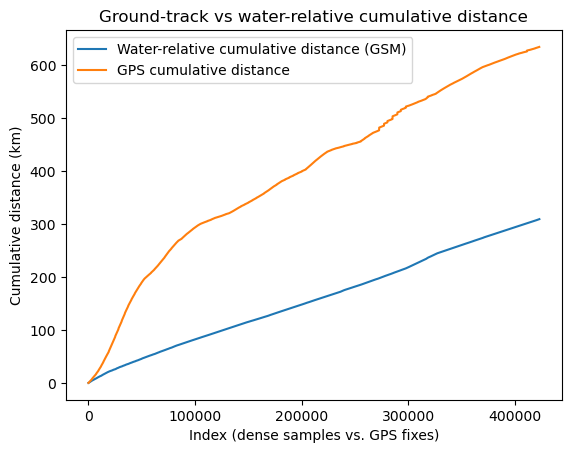

In [23]:
# 4) Snabb jämförelse av totalsumma
rel_total = ds["tot_distance_rel"].isel(sg_data_point=-1).item()
#rel_total = float(ds["tot_distance_rel"][-1])    # [-1] är sista värdet som vi vill jämföra
gps_total = float(cum_distance_gps[-1])
diff_abs = rel_total - gps_total
diff_rel = 100.0 * diff_abs / gps_total if gps_total else np.nan
print(f"GPS total: {gps_total:.2f} km | Water-relative total: {rel_total:.2f} km "
      f"| Diff: {diff_abs:+.2f} km ({diff_rel:+.2f}%)")

# 5) Visualisering
plt.figure()
plt.plot(ds["tot_distance_rel"], label="Water-relative cumulative distance (GSM)")
plt.plot(cum_distance_gps, label="GPS cumulative distance")
plt.xlabel("Index (dense samples vs. GPS fixes)")
plt.ylabel("Cumulative distance (km)")
plt.title("Ground-track vs water-relative cumulative distance")
plt.legend()
plt.show()

GPS total (634 km): Glidern har totalt färdats 634 km över marken (dvs. i jordens koordinater).

Water-relative total (309 km): Om man bara ser på dess egen rörelse i vattnet har den aktivt simmat ungefär hälften så långt.

Skillnaden (~325 km ≈ 51%) beror på att glidern drivits med strömmarna.
→ Havsströmmar har alltså bidragit till ungefär hälften av den totala markrörelsen.

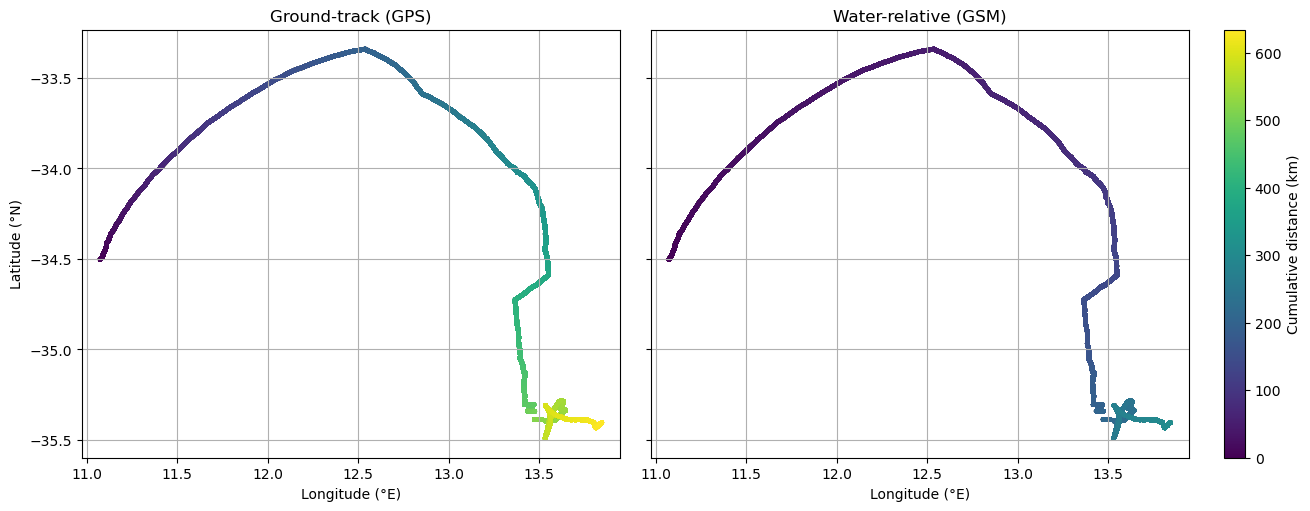

In [24]:
cum_gps_full = np.full(lon.shape, np.nan, float)
cum_gps_full[mask] = cum_distance_gps
xrel = ds["tot_distance_rel"].values.astype(float)

# Välj ett gemensamt intervall (t.ex. 0 → största av de två)
vmin, vmax = 0.0, float(np.nanmax([cum_gps_full, xrel]))
norm = Normalize(vmin=vmin, vmax=vmax)
cmap = "viridis"

fig, axes = plt.subplots(1, 2, figsize=(13, 5), sharey=True, constrained_layout=True)

sc0 = axes[0].scatter(lon, lat, c=cum_gps_full, s=5, cmap=cmap, norm=norm)
axes[0].set_title("Ground-track (GPS)"); axes[0].set_xlabel("Longitude (°E)"); axes[0].set_ylabel("Latitude (°N)"); axes[0].axis("equal")

sc1 = axes[1].scatter(lon, lat, c=xrel, s=5, cmap=cmap, norm=norm)
axes[1].set_title("Water-relative (GSM)"); axes[1].set_xlabel("Longitude (°E)"); axes[1].axis("equal")

# En gemensam colorbar (delad skala)
cbar = fig.colorbar(sc1, ax=axes, pad=0.02)
cbar.set_label("Cumulative distance (km)")
axes[0].grid()
axes[1].grid()
plt.show()

In [25]:
ds

<xarray.Dataset>
Dimensions:                   (sg_data_point: 422669)
Coordinates:
    ctd_depth                 (sg_data_point) float64 0.3879 0.451 ... -0.2057
    longitude                 (sg_data_point) float64 nan nan ... 13.85 13.85
    latitude                  (sg_data_point) float64 nan nan ... -35.4 -35.4
    ctd_time_dt64             (sg_data_point) datetime64[ns] 2025-09-17T10:20...
    distance_rel              (sg_data_point) float64 0.0 6.706e-06 ... 0.00186
    tot_distance_rel          (sg_data_point) float64 0.0 6.706e-06 ... 309.2
Dimensions without coordinates: sg_data_point
Data variables: (12/39)
    time_dt64                 (sg_data_point) datetime64[ns] ...
    depth                     (sg_data_point) float64 ...
    speed_gsm                 (sg_data_point) float64 ...
    ctd_time                  (sg_data_point) datetime64[ns] ...
    pressure                  (sg_data_point) float64 ...
    ctd_pressure              (sg_data_point) float64 0.3911 0.4546 ... -0.2071
    ...                        ...
    temp_qc                   (sg_data_point) float64 nan nan ... 17.89 17.89
    salt_qc                   (sg_data_point) float64 nan nan nan ... nan nan
    SA                        (sg_data_point) float64 nan nan nan ... nan nan
    CT                        (sg_data_point) float64 nan nan nan ... nan nan
    sigma0                    (sg_data_point) float64 nan nan nan ... nan nan
    rho_insitu                (sg_data_point) float64 nan nan nan ... nan nan
Attributes:
    date_created:             2025-10-20 14:26:06
    number_of_dives:          128.0
    files:                    ['C:\\Users\\lollo\\OneDrive - University of Go...
    time_coverage_start:      2025-09-17 10:20:17
    time_coverage_end:        2025-10-13 10:53:44
    geospatial_vertical_min:  -0.2958712021631342
    geospatial_vertical_max:  993.9760316575006
    geospatial_lat_min:       -35.49119608233423
    geospatial_lat_max:       -33.341316666666664
    geospatial_lon_min:       11.073439521461031
    geospatial_lon_max:       13.845082465738725
    processing:               [2025-10-20 14:26:06] imported data with Glider...

### Create clean new dataset

In [26]:
#--- 1) Bygg nytt dataset direkt från DataArrays

ds_clean = xr.Dataset(
    data_vars=dict(
        temperature_qc = ds['temp_qc'],   # behåller dims/attrs från temp_qc
        salinity_qc = ds['salt_qc'],
        absolute_salinity = ds['SA'],
        conservative_temperature = ds['CT'],
        sigma0 = ds['sigma0'],
        density_insitu = ds['rho_insitu'],
        ctd_pressure = ds['ctd_pressure'], 
    ),
    coords=dict(
        dives = ds['dives'],    # Only need to add 'dives' since it wasn't a coord before
    ),
    attrs=dict(
        title="Cleaned Seaglider dataset",
        source="Derived from original ds; includes TEOS-10 and distances rel to currents",
        description="Subset with QC fields, TEOS-10 fields, and along-track coordinates (water-relative)."
    ),
)

ds_clean = ds_clean.rename({"ctd_time_dt64": "time"})
ds_clean["time"].attrs.update({"standard_name": "time", "long_name": "CTD sample time", "history": "ctd_time_dt64 appered from glidertools"})

# If I want to add all of them (not needed):

        # time = ds['ctd_time_dt64'],
        # ctd_depth = ds['ctd_depth'],   
        # latitude = ds['latitude'],
        # longitude = ds['longitude'],
        # dives = ds['dives'],
        # distance_rel = ds['distance_rel'],
        # tot_distance_rel = ds['tot_distance_rel'],

#print(ds_clean)

In [27]:
ds_clean

<xarray.Dataset>
Dimensions:                   (sg_data_point: 422669)
Coordinates:
    ctd_depth                 (sg_data_point) float64 0.3879 0.451 ... -0.2057
    longitude                 (sg_data_point) float64 nan nan ... 13.85 13.85
    latitude                  (sg_data_point) float64 nan nan ... -35.4 -35.4
    time                      (sg_data_point) datetime64[ns] 2025-09-17T10:20...
    distance_rel              (sg_data_point) float64 0.0 6.706e-06 ... 0.00186
    tot_distance_rel          (sg_data_point) float64 0.0 6.706e-06 ... 309.2
    dives                     (sg_data_point) float64 1.0 1.0 ... 128.5 128.5
Dimensions without coordinates: sg_data_point
Data variables:
    temperature_qc            (sg_data_point) float64 nan nan ... 17.89 17.89
    salinity_qc               (sg_data_point) float64 nan nan nan ... nan nan
    absolute_salinity         (sg_data_point) float64 nan nan nan ... nan nan
    conservative_temperature  (sg_data_point) float64 nan nan nan ... nan nan
    sigma0                    (sg_data_point) float64 nan nan nan ... nan nan
    density_insitu            (sg_data_point) float64 nan nan nan ... nan nan
    ctd_pressure              (sg_data_point) float64 0.3911 0.4546 ... -0.2071
Attributes:
    title:        Cleaned Seaglider dataset
    source:       Derived from original ds; includes TEOS-10 and distances re...
    description:  Subset with QC fields, TEOS-10 fields, and along-track coor...

## Save dataset

In [28]:
ds_clean.to_netcdf('02_ds_clean.nc')

### Plot data - overview

In [3]:
ds = xr.open_dataset(r"Data\02_ds_clean.nc")

In [4]:
x = np.array(ds.dives)  # ensures these are arrays
y = np.array(ds.ctd_depth)

C:\Users\lollo\miniconda3\envs\master\Lib\site-packages\glidertools\mapping.py:969: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = Series(z).groupby([x, bins])  # -DB put z into the many bins (like 2D hist)
C:\Users\lollo\miniconda3\envs\master\Lib\site-packages\glidertools\mapping.py:969: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = Series(z).groupby([x, bins])  # -DB put z into the many bins (like 2D hist)
C:\Users\lollo\miniconda3\envs\master\Lib\site-packages\glidertools\mapping.py:969: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version o

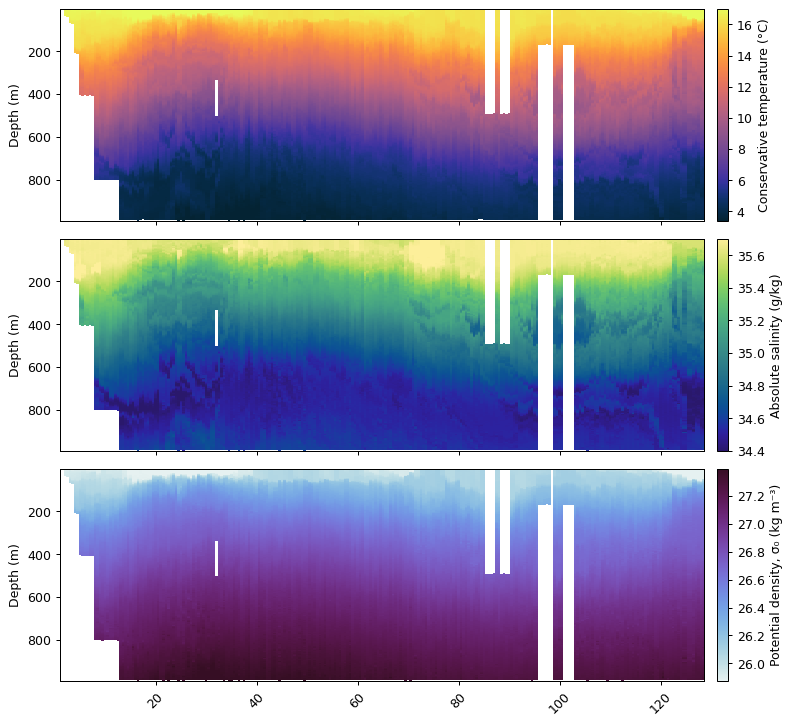

In [5]:
fig, ax = plt.subplots(3, 1, figsize=(9, 8.5), sharex=True, dpi=90)

gt.plot(x, y, ds.conservative_temperature, cmap=cmo.thermal, ax=ax[0])
gt.plot(x, y, ds.absolute_salinity,       cmap=cmo.haline,  ax=ax[1])
gt.plot(x, y, ds.sigma0,                  cmap=cmo.dense,   ax=ax[2])

ax[0].cb.set_label("Conservative temperature (°C)")
ax[1].cb.set_label("Absolute salinity (g/kg)")
ax[2].cb.set_label("Potential density, σ₀ (kg m⁻³)")

ax[0].set_title("")
[a.set_xlabel('') for a in ax]

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()